In [146]:
import Pkg; Pkg.add("DataFrames")
Pkg.add("CSV")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [147]:
using CSV
using DataFrames
using LinearAlgebra

#### Helper function that converts CSV file into an adjacency matrix
These helper functions are used to convert graphs stored in a CSV file into matrices.
This is useful for reading larger graphs stored in separate files that otherwise would be difficult to hard-code into the Julia program.

As an example, a CSV file has the following structure:
```
3
1, 3
1, 2, 3
```
So row 1 (the first node) is connected to the 3rd node only.

Row 2 (the second node) is connected to both the 1st and 3rd nodes.

Row 3 (the third node) is connected to the 1st, 2nd, and 3rd nodes.

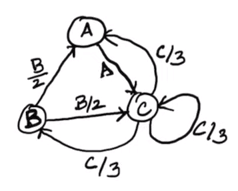

So the resulting adjacency matrix would be:
```
0 1 1
0 0 1
1 1 1
```

In [148]:
function csv_to_adjacency_matrix(file_path::String)
    csv_file = CSV.File(file_path, header=false, silencewarnings=true, ignoreemptyrows=false)

    adjacency_matrix = zeros(Float64, length(csv_file), length(csv_file))

    # Iterate over each row
    for (node, row) in enumerate(csv_file)
        # Iterate over each field in the row
        for field in row
            if !ismissing(field)
                adjacency_matrix[field, node] = 1
            end
        end
    end

    return adjacency_matrix
end

csv_to_adjacency_matrix (generic function with 1 method)

#### Helper function that converts adjacency matrix into a Markov matrix

Normalizes all the columns so the sum of their probabilities equals 1.

For example, the previous adjacency matrix becomes the following Markov matrix:
```
 0.0  0.5  0.333333
 0.0  0.0  0.333333
 1.0  0.5  0.333333
 ```

In [149]:
function normalize_columns(file_path::String)
    # Create a copy of the matrix to avoid modifying the original
    normalized_matrix = csv_to_adjacency_matrix(file_path)
    matrix = copy(normalized_matrix)

    # Get the number of columns
    num_columns = size(matrix, 2)

    for col in 1:num_columns
        # Calculate the sum of the column
        col_sum = sum(matrix[:, col])

        # Avoid division by zero
        if col_sum != 0
            # Normalize the column
            # Periods are there because of floating point values
            normalized_matrix[:, col] .= matrix[:, col] ./ col_sum
        end
    end

    return normalized_matrix
end

normalize_columns (generic function with 1 method)

In [150]:
markov_matrix = normalize_columns("/Users/juanotero/Downloads/15-112/final-project/scripts/the-beatles-125/graph-125.csv")
markov_matrixHits = normalize_columns("/Users/juanotero/Downloads/15-112/final-project/scripts/the-beatles-125/graph-125.csv")

125×125 Matrix{Float64}:
 0.0  0.0    0.0  0.0  0.166667  0.0  …  0.0       0.0  0.0  0.5  0.125  0.0
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.5  0.0    0.0
 0.2  0.0    0.0  0.0  0.166667  0.0     0.333333  0.0  0.0  0.0  0.125  0.0
 0.2  0.125  0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.125  0.0
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.0    0.0
 0.0  0.0    0.0  0.0  0.0       0.0  …  0.0       0.0  0.0  0.0  0.125  0.0
 0.2  0.0    0.0  0.0  0.166667  0.0     0.333333  0.0  0.0  0.0  0.125  0.0
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.125  0.0
 0.2  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.125  0.0
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.0    0.0
 ⋮                               ⋮    ⋱            ⋮                     
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0  0.0  0.0  0.0    0.0
 0.0  0.0    0.0  0.0  0.0       0.0     0.0       0.0

Below, create new markov matrix that accounts for a dampening factor

In [151]:
function includeDampeningFactor(markov_matrix::Matrix{Float64})
    copiedMarkov = copy(markov_matrix)
    dampingFactor = 0.85
    randomPageProb = 1 - dampingFactor
    numberStates = size(copiedMarkov, 1)
    markovMatrixPrime = zeros(Float64, size(copiedMarkov))

    markovMatrixPrime .= (copiedMarkov .* randomPageProb) .+ (dampingFactor / numberStates)
    copiedMarkov .= markovMatrixPrime
    return copiedMarkov
end

newMarkovMatrix = includeDampeningFactor(markov_matrix)

125×125 Matrix{Float64}:
 0.0068  0.0068   0.0068  0.0068  0.0318  …  0.0068  0.0818  0.02555  0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.0818  0.0068   0.0068
 0.0368  0.0068   0.0068  0.0068  0.0318     0.0068  0.0068  0.02555  0.0068
 0.0368  0.02555  0.0068  0.0068  0.0068     0.0068  0.0068  0.02555  0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.0068  0.0068   0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068  …  0.0068  0.0068  0.02555  0.0068
 0.0368  0.0068   0.0068  0.0068  0.0318     0.0068  0.0068  0.02555  0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.0068  0.02555  0.0068
 0.0368  0.0068   0.0068  0.0068  0.0068     0.0068  0.0068  0.02555  0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.0068  0.0068   0.0068
 ⋮                                        ⋱                           
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.0068  0.0068   0.0068
 0.0068  0.0068   0.0068  0.0068  0.0068     0.0068  0.00

Below, assume an initial vector where surfers are distributed evenly among the nodes. Then find the steady state vector to find
distribution of all surfers among the states

In [152]:
function findStateProbabilities(newMarkovMatrix::Matrix{Float64})
    copiedMarkov = copy(newMarkovMatrix)
    surfDistribution = []
    lengthMarkov = size(copiedMarkov, 2)
    startingProbs = 1 / lengthMarkov
    for _ in 1:lengthMarkov
        push!(surfDistribution, startingProbs)
    end
    newSurfers = zeros(lengthMarkov)
    while surfDistribution != newSurfers
        newSurfers = copiedMarkov * surfDistribution
        surfDistribution .= newSurfers
    end
    return surfDistribution
end

orderedStates = findStateProbabilities(newMarkovMatrix)
noDampening = findStateProbabilities(markov_matrix)
println(orderedStates)
println(noDampening)


Any[0.010533157894736815, 0.00950315789473682, 0.03224619047619049, 0.020627619047619034, 0.006899999999999979, 0.007661428571428548, 0.027709348370927308, 0.0076499999999999745, 0.020466190476190457, 0.006799999999999979, 0.006799999999999979, 0.00706315789473682, 0.006799999999999979, 0.006863157894736821, 0.007363157894736819, 0.007704761904761883, 0.007484586466165392, 0.006799999999999979, 0.007099999999999977, 0.006799999999999979, 0.006863157894736821, 0.006799999999999979, 0.006799999999999979, 0.006999999999999978, 0.007113157894736821, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.0069714285714285494, 0.006799999999999979, 0.006799999999999979, 0.006863157894736821, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.007099999999999977, 0.006799999999999979, 0.006799999999999979, 0.00706315789473682, 0.00737142857142855, 0.007039999999999978, 0.006799999999999979, 0.006799999999999979, 0.00722142857142855, 0.008447919799498724, 0.01043476

Below, is the HITS algoirthm. First it converts markov_matrix to have 1s if it has a node
Then, it changes hubScores and authorityScores

In [153]:
function hitsAlgorithmMatrix(markov_matrixHits::Matrix{Float64})
    rows, cols = size(markov_matrixHits)
    modifiedMatrix = zeros(Float64, rows, cols)
    for i in 1:rows
        for j in 1:cols
            if markov_matrixHits[i, j] > 0
                modifiedMatrix[i, j] = 1
            else
                modifiedMatrix[i, j] = 0
            end
        end
    end
    return modifiedMatrix
end

hitsMatrix = hitsAlgorithmMatrix(markov_matrixHits)

125×125 Matrix{Float64}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [154]:
function hits_algorithm(hitsMatrix::Matrix{Float64})
    adjacencyMatrixTran = copy(hitsMatrix)
    adjacencyMatrix = transpose(copy(hitsMatrix))
    numStates = size(adjacencyMatrixTran, 1)
    hubScores = ones(numStates)
    authorityScores = ones(numStates)
    prevHubScores = zeros(numStates)
    prevAuthorityScores = zeros(numStates)
    k = 0
    while hubScores != prevHubScores||
          authorityScores != prevAuthorityScores
        k += 1
        authorityScores .= adjacencyMatrixTran * hubScores
        hubScores .= adjacencyMatrix * authorityScores
        prevAuthorityScores .= authorityScores
        prevHubScores .= hubScores
    end
    authorityScores ./= norm(authorityScores, 2)
    hubScores ./= norm(hubScores, 2)
    println(k)
    return hubScores, authorityScores
end
hub, authority = hits_algorithm(hitsMatrix)

1


([0.13874719302908264, 0.044661113635970806, 0.0, 0.0, 0.092299634847673, 0.0, 0.0, 0.0, 0.0, 0.06550296666609053  …  0.09825444999913578, 0.08217644909018629, 0.11492793242323154, 0.08098548605989374, 0.08396289363562512, 0.0, 0.0, 0.011314148787779272, 0.15661163848347098, 0.0], [0.09132798581280688, 0.066420353318405, 0.5894806357008443, 0.4068246640752306, 0.008302544164800625, 0.0332101766592025, 0.5396653707120406, 0.024907632494401873, 0.3736144874160281, 0.0  …  0.0, 0.008302544164800625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008302544164800625])

In [155]:
function indicesSortedVector(authority)
    testAuthority = copy(authority)
    sortedIndexAuthority = sortperm(testAuthority)
    sortedVectorAuthority = testAuthority[sortedIndexAuthority]
    
    return sortedIndexAuthority, sortedVectorAuthority
end

organizedPagesIndex, organizedPages = indicesSortedVector(authority)
organizedPagesIndexDamp, organizedPagesDamp = indicesSortedVector(orderedStates)
organizedPagesIndexNoDamp, organizedPagesNoDamp = indicesSortedVector(noDampening)
println("HIT")
println(organizedPagesIndex)
println(organizedPages)
println("Dampening")
println(organizedPagesIndexDamp)
println(organizedPagesDamp)
println("No Dampening")
println(organizedPagesIndexNoDamp)
println(organizedPagesNoDamp)



HIT
[10, 11, 13, 18, 20, 22, 23, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 42, 43, 47, 49, 51, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 72, 73, 76, 80, 82, 83, 84, 85, 88, 89, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 5, 14, 19, 21, 24, 29, 32, 36, 41, 50, 52, 56, 58, 75, 77, 78, 92, 117, 125, 12, 39, 40, 68, 71, 79, 86, 90, 8, 16, 25, 44, 57, 69, 6, 15, 17, 48, 81, 91, 74, 2, 45, 87, 1, 46, 9, 4, 7, 3]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008302544164800625, 0.008302544164800625, 0.008302544164800625, 0.008302544164800625, 0.0083025

84, 85, 88, 89, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 14, 21, 32, 75, 125, 5, 52, 56, 77, 29, 24, 58, 78, 86, 41, 12, 39, 19, 36, 117, 25, 68, 50, 92, 44, 90, 69, 79, 15, 40, 17, 8, 6, 16, 81, 48, 57, 91, 71, 45, 87, 74, 2, 46, 1, 9, 4, 7, 3]
Any[0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006799999999999979, 0.006